In [ ]:
# загрузка диерктории с данными
!git clone https://github.com/pavel-blinov/RuMedBench.git

In [10]:
# установка доп зависимостей
!pip install seqeval
!pip install datasets
!pip install transformers -U
!pip install accelerate -U
!pip install evaluate

In [4]:
import torch
torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_flash_sdp(False)

In [5]:
import pandas as pd

train = pd.read_json('/kaggle/working/RuMedBench/data/RuMedTop3/train_v1.jsonl',
                     lines=True)

test = pd.read_json('/kaggle/working/RuMedBench/data/RuMedTop3/test_v1.jsonl',
                     lines=True)

dev = pd.read_json('/kaggle/working/RuMedBench/data/RuMedTop3/dev_v1.jsonl',
                     lines=True)

In [6]:
train.code.nunique(), train.shape[0]

(105, 4690)

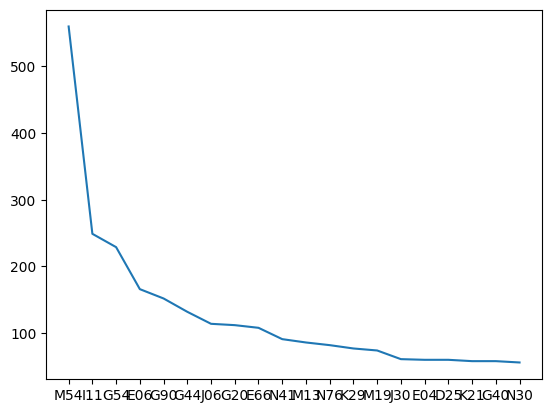

In [7]:
# встречаемость диагнозов в выборке
import matplotlib.pyplot as plt
plt.plot(train.code.value_counts()[0:20])

# Mistral 7b

In [ ]:
# доп зависимости для LLM
!pip install -q -U bitsandbytes
!pip install -q -U accelerate
!pip install -q -U einops
!pip install -q -U safetensors

In [ ]:
from huggingface_hub import login
login(token="[YOUR TOKEN]")

In [ ]:
# загрузка квантизированной модели

import torch
from transformers import BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)
model_id = "mistralai/Mistral-7B-Instruct-v0.2"

from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

#model_4bit = AutoModelForCausalLM.from_pretrained( model_id, device_map="auto",quantization_config=quantization_config, )
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [ ]:
# настройка пайплайна генерации

pipe = pipeline(
        "text-generation",
        model=model_4bit,
        tokenizer=tokenizer,
        device_map="auto",
        max_length=250,
        batch_size=32,
        do_sample=True,
        truncation=True,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
)

pipe.tokenizer.pad_token_id = tokenizer.eos_token_id

In [13]:
# получение input промптов

from tqdm import tqdm
tqdm.pandas()

train_synthetic = train.copy()
train_synthetic['symptoms_prompt'] = train_synthetic['symptoms'].apply(lambda x: '[INST]You are medical expert, try to paraphrase the following anamnesis preserving the key information about patient condition: {0} Answer only in Russian[/INST]'.format(x))

In [14]:
# удалить все что больше 250 токенов

# train_synthetic['symptoms_prompt'].apply(lambda x: len(tokenizer(x)['input_ids'])).hist()

filtr = train_synthetic['symptoms_prompt'].apply(lambda x: len(tokenizer(x)['input_ids']) < 250)
train_synthetic = train_synthetic[filtr]

In [ ]:
# generation
from tqdm import tqdm

results = []
CHUNK_SIZE = 32
for chunk in tqdm(range(train_synthetic.shape[0] // CHUNK_SIZE + 1)):
    descr = train_synthetic[CHUNK_SIZE * chunk: CHUNK_SIZE * (chunk+1)]['symptoms_prompt'].to_list()
    res = pipe(descr, temperature=0.1, top_p=0.9)
    results += res

In [ ]:
import pickle

with open('outfile', 'wb') as fp:
    pickle.dump(results, fp)

In [ ]:
from IPython.display import FileLink
FileLink(r'outfile')

# Generated data comparison

In [16]:
import pickle

with open ('/kaggle/input/mistral-4b-generated-data/outfile', 'rb') as fp:
    itemlist = pickle.load(fp)

In [17]:
itemlist = [i[0]['generated_text'][i[0]['generated_text'].index('[/INST]')+8:] for i in itemlist]
itemlist[0]

'Пациент сообщает о боли в всех суставах, особенно в крупных, продолжительностью не более двух недель. Такое состояние наблюдалось месяц назад, причиной которого послу'

In [18]:
train_synthetic.drop(columns=['symptoms_prompt'], inplace=True)

In [19]:
train_synthetic['symptoms_paraphrase'] = itemlist

In [20]:
train_synthetic['symptoms_paraphrase'] = \
    train_synthetic['symptoms_paraphrase']\
    .progress_apply(lambda x: x[:x.find('\n\n')])

100%|██████████| 4453/4453 [00:00<00:00, 328824.57it/s]


In [21]:
train_synthetic[['symptoms', 'symptoms_paraphrase']].values[20:30]

array([['колебания АД, нарушение сна, боль в лобной области и глазниц, ломящего характера, ощущение "песка" в глазах, трудно читать, усиливается больв глазных яблоках',
        'Колебания артериального давления, нарушение сонного цикла, болезненные ощущения в лобной области и углах глаз, ломящего характера, присутствует ощущение "песка" в гл'],
       ['Высыпания на коже.Сопровождаются зудом,жжением.',
        'Кожные высыпания сопровождаются жжением и болем. (Skin rashes are accompanied by burning and pain.'],
       ['Отмечает ус кашель с продуктивным кашлем, температура нормализовалась, заложенность сохраняется',
        'Пациент сообщает об кашле с выделением слизи, температура тела нормализовалась, но блог в носу сохраняется.'],
       ['боль в области левой лопатки, в межлопаточной области, усиливается при сидении, при занятияз спортом.',
        'Боль в области левой лопатки, в межлопатковой области, усиливается при сидении и при занятии спортом.'],
       ['общую слабость, сонл

<Axes: >

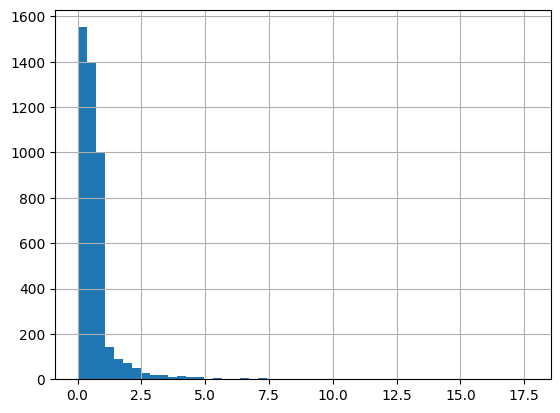

In [22]:
# во сколько раз отличаются разницы в символах относительно длины оригинального текста
((train_synthetic['symptoms'].apply(len) - train_synthetic['symptoms_paraphrase'].apply(len)).abs()\
    / train_synthetic['symptoms'].apply(len)).hist(bins=50)

In [27]:
# во сколько раз отличаются разницы в символах отностильно длины оригинального текста
train_synthetic['thr'] = ((train_synthetic['symptoms'].apply(len) - train_synthetic['symptoms_paraphrase'].apply(len)).abs()\
    / train_synthetic['symptoms'].apply(len))

train_synthetic['thr'].quantile(0.8)

train_synthetic = train_synthetic[train_synthetic['thr'] < train_synthetic['thr'].quantile(0.8)]

In [28]:
train_synthetic[train_synthetic['thr'] < 0.2][['symptoms', 'symptoms_paraphrase', 'thr']].values[3]

array(['Боли в области левой пятки, затруднения при ходьбе, усиление болей при нагрузке сохраняются. Нагрузка ощутима, болезненность усиливается.',
       'В области левой пятки пациента чувstвуются боли, при ходьбе ему трудно, увеличение болезненности при нагрузке сохраняется. Нагрузка ощутима, болезне',
       0.08029197080291971], dtype=object)

In [35]:
train_synthetic[train_synthetic['thr'] > 0.5][['symptoms', 'symptoms_paraphrase', 'thr']].loc[38].values

array(['Общую слабость, колебания ад до 150/85, тахикардия. принимает леркомен 10 мг при снижении давления ощущения ватных рук и ног. сухость во рту, боли в поясничном отделе позвоночника плохой сон. забывчивость.',
       'Общая слабость, колебания артериального давления до 150/85 мм рт. ст., тахика',
       0.624390243902439], dtype=object)

In [45]:
#train_synthetic['symptoms'] = train_synthetic['symptoms_paraphrase']
#train_synthetic.drop(columns=['thr', 'symptoms_paraphrase'], inplace=True)

pd.concat([train, train_synthetic]).to_excel('train_augmented', engine='openpyxl')